In [1]:
import os 
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [3]:
# load data 
os.chdir(r'/home/qshan/Desktop/Repos/Big_Data_Projects/Recommender_System/Matrix_Factorization')
df = pd.read_csv('../data/ml-20m/small_ratings.csv')
df.head()

,userId,movieId,rating,movie_idx
0,7307,1,4.5,10
1,7307,10,2.5,68
2,7307,19,3.5,143
3,7307,32,5.0,19
4,7307,39,4.5,85


In [4]:
# number of users and movies 
N = df.userId.max() + 1
M = df.movie_idx.max() + 1
print('Max of users id, N =', N, '\n')
print('Max movies id M, =', M, '\n')

Max of users id, N = 10000 

Max movies id M, = 2000 



In [6]:
# randomly shuffle to obtain train and test data 
df = shuffle(df)
cutoff = int(0.8 * len(df))
df_train = df.iloc[ :cutoff]
df_test = df.iloc[cutoff: ]

In [7]:
# initialization 

# latent dimensionality 
K = 10 
# global mean 
mu = df_train.rating.mean()
epochs = 10 
# penalty 
lambda_ = 10.

In [8]:
# Keras model
# two inputs with batch size = 1 
u = Input(shape = (1, ))
m = Input(shape = (1, ))

# (N, 1, K), for a sequence of len 1 
u_embedding = Embedding(N, K, embeddings_regularizer = l2(lambda_))(u) 
m_embedding = Embedding(M, K, embeddings_regularizer = l2(lambda_))(m)


# Keras model bias terms 
u_bias = Embedding(N, 1, embeddings_regularizer = l2(lambda_))(u) # (N ,1 ,1)
m_bias = Embedding(M, 1, embeddings_regularizer = l2(lambda_))(m) # (M, 1, 1)

# multiply user vector and movie vector together 
# collapse on (sum over) the K size axis of (N, 1, K) for u_embedding
x = Dot(axes = 2)([u_embedding, m_embedding]) # (N, 1, 1)

x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)


# flatten 
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)

y = Concatenate()([u_embedding, m_embedding]) # (N, 2K)
y = Dense(400)(y)
y = Activation('elu')(y)
# y = Dropout(0.5)(y)
y = Dense(1)(y)


Instructions for updating:
Colocations handled automatically by placer.


In [9]:
##### merge
x = Add()([x, y])

# build model 
model = Model(inputs = [u, m], outputs = x)

# compile 
# if there is penalty, mse from loss includes regularization, will be bigger than real mse (metrics mse)
model.compile(loss = 'mse', optimizer = SGD(lr = 0.08, momentum = 0.9), metrics = ['mse'])

# fit model 
r = model.fit(
              x = [df_train.userId.values, df_train.movie_idx.values],
              y = df_train.rating.values - mu,
              epochs = epochs, 
              batch_size = 128, 
              validation_data = ([df_test.userId.values, df_test.movie_idx.values],
                                  df_test.rating.values - mu))



Instructions for updating:
Use tf.cast instead.
Train on 4313620 samples, validate on 1078405 samples
Epoch 1/10
4313620/4313620 [==============================] - 188s 44us/step - loss: 1.3335 - mean_squared_error: 1.0403 - val_loss: 1.0763 - val_mean_squared_error: 1.0348
Epoch 2/10
4313620/4313620 [==============================] - 198s 46us/step - loss: 1.0629 - mean_squared_error: 1.0404 - val_loss: 1.0834 - val_mean_squared_error: 1.0402
Epoch 3/10
4313620/4313620 [==============================] - 203s 47us/step - loss: 1.0629 - mean_squared_error: 1.0404 - val_loss: 1.0950 - val_mean_squared_error: 1.0358
Epoch 4/10
4313620/4313620 [==============================] - 205s 47us/step - loss: 1.0629 - mean_squared_error: 1.0404 - val_loss: 1.0812 - val_mean_squared_error: 1.0358
Epoch 5/10
4313620/4313620 [==============================] - 206s 48us/step - loss: 1.0628 - mean_squared_error: 1.0404 - val_loss: 1.0892 - val_mean_squared_error: 1.0411
Epoch 6/10
4313620/4313620 [=====

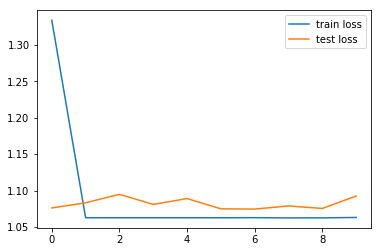

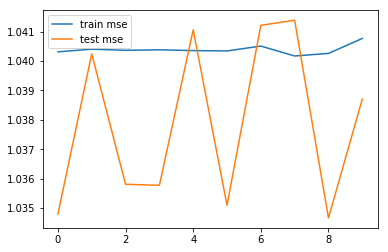

In [10]:
# plot 
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mean_squared_error'], label="train mse")
plt.plot(r.history['val_mean_squared_error'], label="test mse")
plt.legend()
plt.show()